# ДЗ 1, часть 1. Метод максимального правдоподобия

Имя, Фамилия: Шашлова Елизавета

группа: 224

**Оценка(для проверяющего):** 0 из 10

**Дедлайн:** одновременно с частью 3

In [2]:
#all imports here please
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


## Задача 1. Свойства ММП оценок для модели нормального распределения (2 балла)

Рассмотрим следующую модель из независимых векторных наблюдений $X_1,..,X_n$:

$$X_i \overset{iid}{\sim} \mathcal{N}(\mu, \Sigma).$$

Постройте и исследуйте оценку для вектора матожиданий $\mu$ и ковариационной матрицы $\Sigma$ методом максимального правдоподобия.

**В помощь:** Если дифференцировать функцию $f: \mathbb{R}^{m \times n} \to \mathbb{R}$ по ячейкам входной матрицы, то получится матрица из производных, обозначаемая $\nabla_A f(A)$. Условие первого порядка для оптимизации записывается так же, как и в привычных вам случаях, нужно приравнять производные к нулю. Можете использовать [таблицу](https://en.wikipedia.org/wiki/Matrix_calculus#Scalar-by-matrix_identities) для получения оценок.

### Правдоподобие

*Запишите функцию правдоподобия и ее логарифм.*

ВАШЕ РЕШЕНИЕ И ОБОСНОВАНИЯ ТУТ...

### ММП-оценка

*Найдите выражение для ММП-оценки и сравните решение с решением в одномерном случае.*

ВАШЕ РЕШЕНИЕ И ОБОСНОВАНИЯ ТУТ...

## Задача 2. Свойства ММП оценок для модели равномерного распределения (2 балла)

Рассмотрим модель выборки $X_1,..,X_n$ из наблюдений

$X_i \overset{iid}{\sim} U[0,a]$

### Правдоподобие

*Запишите функцию правдоподобия и ее логарифм.*

ВАШЕ РЕШЕНИЕ И ОБОСНОВАНИЯ ТУТ...

### ММП-оценка параметра $a$

*Найдите выражение для ММП-оценки параметра $a$*.

ВАШЕ РЕШЕНИЕ И ОБОСНОВАНИЯ ТУТ...

## Задача 3. Оцениваем модель охлаждения (3 балла)

[(Другой) закон Ньютона](https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling)  -- простая математическая модель охлаждения(или нагревания) тела

$$
\frac{dT}{dt} = r (T_{env} - T(t)),
$$

это дифференциальное уравнение первого порядка, которое в непрерывном (то есть, в любой момент $t$) показывает, какая должна быть температура у тела, если дана начальная температура $T(0)=T_0$. Температурные единицы измерения -- Кельвины, $r$ -- это некоторая константа, зависящая от самого тела, от состава среды и т.п. . Это приближённый закон.

Вообще константа $r$ неизвестна априори и если мы хотим делать какое-то устройство, которое использует такую модель, мы должны как-то оценить $r$. Один из вариантов -- померить температуру среды (полагаем её константной), нагреть тело до какой-то температуры $T_0$, а потом оставить остывать и замерять через разные промежутки времени его температуру. По итогам таких наблюдений получится датасет
$$
T_{t_0},T_{t_1},..,T_{t_n}, ~~ t_0=0.
$$

Осталось придумать вероятностную модель. Например, мы можем записать приближённое дискретизированное по времени уравнение, используя метод Эйлера:

$$
T_{t_{i+1}} = T_{t_{i}} + r (T_{env} - T_{t_{i}}) \Delta t_i, ~~  \Delta t_i = t_{i+1} - t_i,
$$

а дальше предлагать разные варианты оценивания.

### Правдоподобие

С учётом ошибок измерений и необъяснимых факторов среды, договорившись измерять температуру через равные промежутки времени $\Delta t_i= \Delta t$, можно предположить модель, очень похожую на модель авторегрессии $AR(1)$:

$$
T_{i+1} = (1 - r\Delta t)T_{i} + r T_{env} \Delta t + \varepsilon_{i+1}, ~~ \varepsilon_{i+1} \sim_{iid} N(0,\sigma^2).
$$

1. Предполагая $T_{env}$ и $\Delta t$ данными, определите параметры модели, которые нужно оценивать и выведите функцию лог-правдоподобия.

2. Выведите оценки ММП для данной модели.

ВАШЕ РЕШЕНИЕ И ОБОСНОВАНИЯ ТУТ...

### Пишем модель

Имплементируйте класс модели, используя шаблон ниже и проведите некоторые тесты, чтобы убедиться, что он рабочий.

In [36]:
class CoolingModel:

    def __init__(self, r, delta, sigma2):
        self.r = r
        self.sigma2 = sigma2
        self.delta = delta

    def step(self,T0,Tenv):
        """Makes one step in time

        Args:
            T0 (float[]): current temperature (NTraj,)
            Tenv (float[]): current environment temperature (NTraj,)
        Returns:
            T (float[]): next temperature (NTraj,)
        """
        noise = np.random.normal(0, np.sqrt(self.sigma2), size=T0.shape)
        T = (1 - self.r * self.delta) * T0 + self.r * Tenv * self.delta + noise
        return T

    def simulate(self, T0, NSteps, Tenv):
        """Simulates NTraj trajectories of cooling process

        Args:
            T0 (float[]): initial temperature (NTraj,)
            NSteps (int): number of time steps
            Tenv (float): environment temperature
        Returns:
            trajs (float[]): simulation result (NTraj,NSteps)
        """
        Tenv = np.ones_like(T0)*Tenv
        trajs = np.zeros([T0.shape[0],NSteps+1])
        trajs[:,0] = T0
        for step in range(1, NSteps + 1):
            trajs[:, step] = self.step(trajs[:, step - 1], Tenv)

        return trajs


    def fit(self, temps, Tenv):
        """Fits the model using the given data

        Args:
            temps (float[]): temperatures (N,)
            Tenv (float): environment temperature
        """
        # Количество точек данных
        n = len(temps)

        # Оценка параметра r с помощью метода максимального правдоподобия (используем np.mean)
        temps_shifted = temps[:-1]  # temps[i-1] для i в диапазоне 1 до n
        delta_temps = temps[1:] - temps[:-1]  # temps[i] - temps[i-1] для i в диапазоне 1 до n

        numerator = np.mean((temps_shifted - Tenv) * delta_temps)
        denominator = np.mean((temps_shifted - Tenv) ** 2)

        self.r = (-1) * numerator / (self.delta * denominator)

        # Оценка для дисперсии sigma^2
        residuals = delta_temps + self.r * self.delta * (temps_shifted - Tenv)
        self.sigma2 = np.mean(residuals ** 2)

Попробуйте для нарисовать несколько возможных траекторий, код ниже должен показать график.

In [37]:
#params
r = 0.2 #1/sec
sigma2=0.02

#time stuff
NSteps = 1000
finalTime = 100
delta=finalTime/NSteps #sec

#number of simulations
NTrajs = 5

#temperatures
T0 = np.ones([NTrajs])*280 #K
Tenv = 300 #K

procModel = CoolingModel(r,delta,sigma2)
trajs = procModel.simulate(T0,NSteps,Tenv)

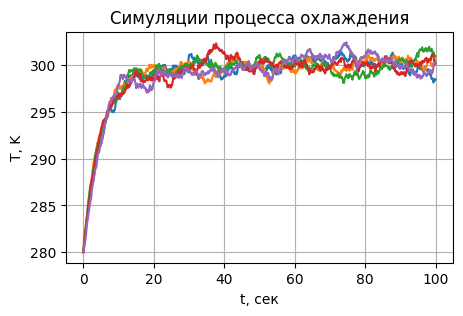

In [38]:
ts = np.arange(0,finalTime+delta/2,delta) #+delta/2 to include the last value

f, ax = plt.subplots(figsize=(5,3))

ax.grid()
ax.set_title("Симуляции процесса охлаждения")
ax.set_xlabel("t, сек")
ax.set_ylabel("T, K")
ax.plot(ts,trajs.T)
plt.show()

Каждая траектория начинается с температуры $ T_0 = 280 \, \text{K} $ и быстро поднимается, приближаясь к температуре окружающей среды. По достижении температуры около $ T_{\text{env}} = 300 \, \text{K} $, каждая траектория начинает колебаться около этой точки. Эти колебания обусловлены случайным шумом, который учитывает непредсказуемые факторы среды и ошибки измерений. Хотя траектории слегка отличаются из-за добавленного случайного шума, все они следуют схожей общей тенденции.


### Оценка модели по данным

Допишите метод `fit` в класс модели и оцените параметры, используя данный датасет, с помощью метода максимального правдоподобия. Данные в формате ``pkl``, загружаются как словарь.

In [39]:
with open("/content/coolingModel.pkl","rb") as f:
    dd = pkl.load(f)
    temps = dd['temperature']
    Tenv = dd['Tenv']
    delta = dd['delta']

In [41]:
#random init
procModel = CoolingModel(0.1,delta,0.1)
procModel.fit(temps, Tenv)
print(f"Parameters:  r={procModel.r},sigma^2={procModel.sigma2}")

Parameters:  r=0.03608793300832803,sigma^2=0.015218767214311636


Нарисуйте несколько траекторий оценённой модели более тонкими и прозрачными линиями и сравните с вашими данными.

In [61]:
NTrajs = 7
T0 = np.array([temps[0]] * NTrajs)
trajs = procModel.simulate(T0, len(temps) - 1, Tenv)


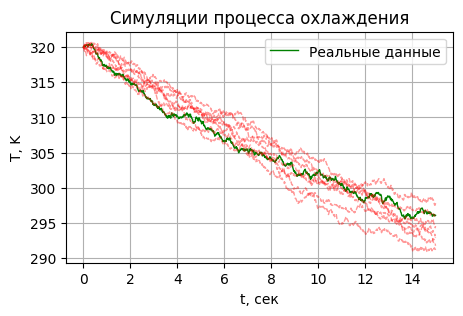

In [63]:
ts = np.arange(0,finalTime+delta/2,delta) #+delta/2 to include the last value

f, ax = plt.subplots(figsize=(5,3))

ax.grid()
ax.set_title("Симуляции процесса охлаждения")
ax.set_xlabel("t, сек")
ax.set_ylabel("T, K")

ax.plot(ts, temps, label='Реальные данные', linewidth=1, color='green')

for i in range(NTrajs):
    ax.plot(ts, trajs[i, :], color='red', linewidth=1, alpha=0.4, linestyle='--')

plt.legend()
plt.show()

Симулированные траектории имеют достаточно хорошее соответствие с реальными данными в общей тенденции — постепенное снижение температуры.
Наблюдается некоторое отклонение между симулированными траекториями и реальными данными, возможно из-за случайных факторов и шумов.

## Задача 4. Дискретная модель цен (3 балла)

### Броуновское движение

[Броуновское движение (или по-другому Винеровский процесс)](https://en.wikipedia.org/wiki/Wiener_process)  - это случайный процесс (набор случайных величин) $\{W_t\}_{t \geq 0}$ c непрерывным временем, который задётся так:

* $W_0 = 0$

* $W_t - W_s \sim \mathcal{N}(0, t-s)$, $0 \leq s \leq t$

* $W_{t_2} - W_{t_1}$ и $W_{t_4} - W_{t_3}$  независимы для $0 \leq t_1 \leq t_2 \leq t_3 \leq t_4$

Мы можем попытаться нарисовать значения процесса в любом конечном наборе точек $(t_i)_{i=0}^{N_t}$, это будут зависимые случайные величины. Удобнее всего для симуляции пользоваться последним свойством: если обозначить $\Delta t_i = t_{i+1} - t_i$, то

$$
W_{t_{i+1}} = W_{t_i} + \varepsilon_{i+1},
$$

где $W_{t_0}$ задано, а шумы $\varepsilon_{i+1} \sim N(0, \Delta t_i)$ независимы.

### Симуляция

*Реализуйте симуляцию этого дискретизированного процесса $(W_{t_i})_{i=0}^{N_t}$, используя данную сетку по времени $(t_i)_{i=0}^{N_t}$.*

In [65]:
class BrownianMotion:

    def __init__(self):
        pass

    def sample(self, ts, Ntraj):
        """Returns a discrete set of observations

        Args:
            ts (float[]): time grid (T,)
            Ntraj (int): number of trajectories to sample
        Returns
            trajs (float[]): (Ntraj,T) samples
        """
        T = len(ts)
        trajs = np.zeros([Ntraj,T])

        trajs = np.zeros([Ntraj, T])
        for i in range(1, T):
            delta_t = ts[i] - ts[i - 1]
            epsilon = np.random.normal(0, np.sqrt(delta_t), size=Ntraj)
            trajs[:, i] = trajs[:, i - 1] + epsilon
        return trajs

Проверим! Нарисуйте набор семплов наблюдений $W_{t_0},..,W_{t_{N_{t}}}$ из модели Броуновского движения при $t_0=0$ и $W_{t_0} = 0$.

In [66]:
#example
Ntraj = 50
T=3
Nt = 100#number of time subdivisions
delta = T/Nt
ts = np.arange(0,T+delta/2 ,delta)# discrete points from [0,T]

bmProc = BrownianMotion()
trajs = bmProc.sample(ts,Ntraj)

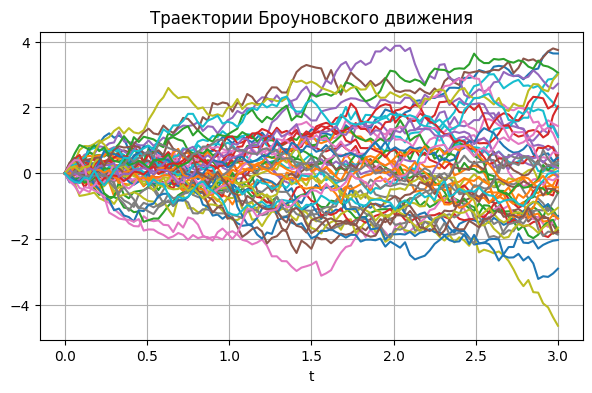

In [67]:
f, ax = plt.subplots(figsize=(7,4))

ax.grid()
ax.set_title("Траектории Броуновского движения")
ax.set_xlabel("t")
ax.plot(ts,trajs.T)
plt.show()#if needed

## Геометрическое Броуновское движение

Геометрическое Броуновское движение (GBM) -- это модель

$$
S_t = S_0 \exp[(\mu - \frac{\sigma^2}{2})t + \sigma W_t],
$$

где параметр $\mu$ называется сносом (он связан с безрисковой процентной ставкой на рынке и выплатами по активу, например, дивидендами акции), а $\sigma$ -- волатильностью. Это один из базовых кирпичиков моделей финансовых рядов.

Пусть мы пронаблюдали набор значений $S_{t_1},..,S_{t_N}$, давайте получим оценки параметров и попробуем оценить их по данным.


### Параметры

Будем оценивать 𝜇 и 𝜎

### Правдоподобие

*Запишите функцию правдоподобия для модели данных и ее логарифм.*

### ММП-оценки

*Найдите выражение для ММП-оценок параметров.*


ВАШЕ РЕШЕНИЕ И ОБОСНОВАНИЯ ТУТ...

### Пишем модель

In [ ]:
class GBM:

    def __init__(self,mu,sigma):
        self.mu = mu
        self.sigma = sigma
        self.brownMotion = BrownianMotion()

    def sample(self, x0, ts):
        """Returns a discrete set of observations

        Args:
            x0 (float[]): set of initial conditions x_{ts[0]}  (Ntraj,)
            ts (float[]): time grid (T,)
        Returns
            trajs (float[]): (Ntraj,T) samples
        """
        Ntraj = x0.shape[0]
        #YOUR CODE
        #trajs =??
        return trajs

    def fit(self, st, delta):
        """Fits the parameters given the data (assuming the step size is constant and equal delta)

        Args:
            st (float[]): observations (T,)
            delta (flaot): time step size
        """
        #YOUR ESTIMATION HERE
        #self.mu = ??   self.sigma = ??s

Протестируем.

In [ ]:
#example
Ntraj = 50
T=50
Nt = 5000#number of time subdivisions
delta = T/Nt
ts = np.arange(0,T+delta/2 ,delta)# discrete points from [0,T]

mu=0.02
sigma=0.27
gbmProc = GBM(mu, sigma)

x0 = np.ones([Ntraj])*100
trajs = gbmProc.sample(x0,ts)

In [ ]:
f, ax = plt.subplots(figsize=(7,4))

ax.grid()
ax.set_title("Траектории GBM")
ax.set_xlabel("t")
ax.plot(ts,trajs.T)
plt.show()#if needed

### Оценка модели по данным

Допишите метод `fit` в класс модели и оцените параметры, используя данный датасет, с помощью метода максимального правдоподобия. Данные в формате ``pkl``, загружаются как словарь.

In [ ]:
# load data
with open("./gbmData.pkl", "rb") as f:
    dd=pkl.load(f)
    #YOUR CODE
    #read the data

In [ ]:
#random init
gbmProc = GBM(0.01, 0.01)
#gbmProc.fit(??)

print('mu_MLE', gbmProc.mu)
print('sigma_MLE', gbmProc.sigma)

Нарисуйте несколько траекторий оценённой модели более тонкими и прозрачными линиями и сравните с вашими данными.

In [ ]:
#generating new trajectories
Ntraj = 10

#
#trajs = gbmProc.sample(??)

In [ ]:
f, ax = plt.subplots(figsize=(7,4))

ax.grid()
ax.set_title("Траектории GBM")
ax.set_xlabel("t")
#YOUR CODE
#any plots?
ax.legend(["Data","Samples"])
plt.show()#if needed

ВАШ КОММЕНТАРИЙ ЗДЕСЬ